In [ ]:
#|default_exp cnn_virus.data

In [ ]:
#|hide
from __future__ import annotations
from ecutilities.ipython import nb_setup
from fastcore.test import test_fail
from nbdev import show_doc, nbdev_export
from pprint import pprint

import numpy as np
import pandas as pd

In [ ]:
#| hide
nb_setup()

# ON_COLAB, p2dataroot, p2data = setup_nb(_dev=True)

Set autoreload mode


In [ ]:
#|export
from ecutilities.core import validate_path
from functools import partial, partialmethod
from metagentools.bio import q_score2prob_error
from metagentools.core import TextFileBaseReader, JsonFileReader
from pathlib import Path
from typing import Any, Optional

import json
import numpy as np
import re
import tensorflow as tf
import warnings

In [ ]:
#|hide
print(f"Tensorflow version: {tf.__version__} - Expected 2.8.2")

Tensorflow version: 2.8.2 - Expected 2.8.2


# data

> Data preprocessing functions, data loaders, ...

# Data structure for CNN Virus project

The following diagram shows the different types of data from raw data to processed data to data used by the CNN Virus model

In [ ]:
#| hide
# TODO: update the diagram: (fq + aln); ds + read_info

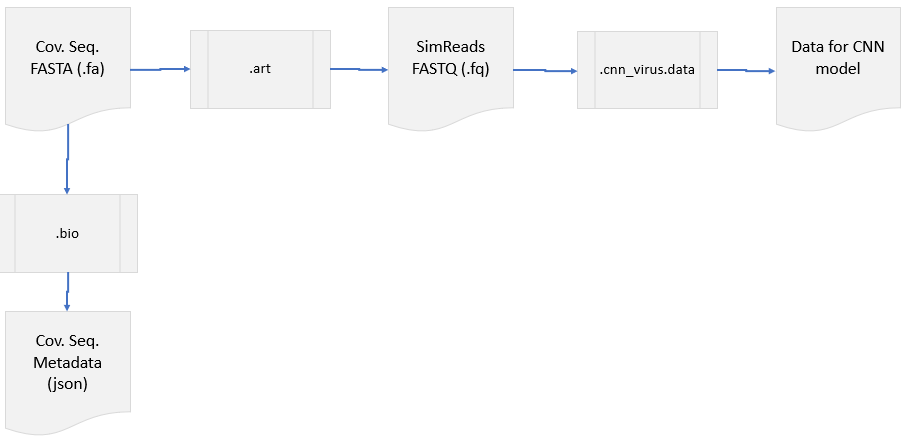

## Corona Virus Sequence Files

All corona virus sequences are available as FASTA files.

Examples of corona virus sequence files (fasta) with different number of sequences used in the project:
```
data
  |--cov_data
  |    |--cov_virus_sequences_hundred.fa
  |    |--cov_virus_sequences_twenty_five.fa
  |    |--cov_virus_sequences_ten.fa
  |    |--cov_virus_sequences.fa
```

Those fasta files have the following format (showing 5 sequences):
```
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D	scient
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTA ...
>11128:ncbi:2 [LC494191]
CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCCTATGGGCGTAGATTTTTCATAGTGGTGTCT ...
>31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43	scientific name
ATCTCTTGTTAGATCTTTTTGTAATCTAAACTTTATAAAAACATCCACTCCCTGTAATCTATGCTTGTGGGCGTAGATTTTTCATAGTGGTGTTTATATTCATTTCTGCT ...
>277944:ncbi:4 [LC654455]	277944	ncbi	4 [LC654455] 277944	Human coronavirus NL63	scientific name
ATTTTCTTATTTAGACTTTGTGTCTACTCTTCTCAACTAAACGAAATTTTTCTAGTGCTGTCATTTGTTATGGCAGTCCTAGTGTAATTGAAATTTCGTCAAGTTTGTAA ...
>11120:ncbi:5 [MN987231]	11120	ncbi	5 [MN987231] 11120	Infectious bronchitis virus	scientific name
TCCTAAGTGTGATATAAATATATATCATACACACTAGCCTTGCGCTAGATTTCTAACTTAACAAAACGGACTTAAATACCTACAGCTGGTCCCTATAGGTGTTCCATTGC ...
....
```

Metadata can be parsed from the definition line for further use.

Example 1:

- Definition Line:
```ascii
    >2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name
```
- Metadata:
    - `seqid` = `2591237:ncbi:1`
    - `taxonomyid` = `2591237`
    - `source` = `ncbi`
    - `seqnb` = `1`
    - `accession` = `MK211378`
    - `species` = `Coronavirus BtRs-BetaCoV/YN2018D`

Example 2:

- Definition Line
```ascii
    >11128:ncbi:2 [LC494191]
```

- Metadata:
    - `seqid` = `11128:ncbi:2`
    - `taxonomyid` = `11128`
    - `source` = `ncbi`
    - `seqnb` = `2`
    - `accession` = `LC494191`
    - `species` = `''`

## Simulated Read Files

Simulated reads information is split between two files:

- FASTQ (`.fq`) files providing the read sequences and their ASCII quality scores
- ALN (`.aln`) files with alignment information

Example of read sequence FASTA and ALN files used in this project

```ascii
data
  |--cov_simreads
  |    |--single_25seq_50bp
  |    |    |--single_25seq_50bp.aln
  |    |    |--single_25seq_50bp.fq
  |    |--single_25seq_150bp
  |    |    |--single_25seq_150bp.fq
  |    |    |--single_25seq_150bp.aln
  |    |--single_100seq_50bp
  |    |    |--single_100seq_50bp.fq
  |    |    |--single_100seq_50bp.aln
  |    |--single_100seq_150bp
  |    |    |--single_100seq_150bp.fq
  |    |    |--single_100seq_150bp.aln
  ```

**FASTQ** (`.fq`) files generated by ART Illumina have the following structure (showing 5 reads):

```ascii
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
@2591237:ncbi:1-60399
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
+
BCBCCFGGGGGGGG1CGGGG<GGBGGGGGFGCGGGGGGDGGG/GG1GGGG
@2591237:ncbi:1-60398
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
+
CCCCCGGGEGG1GGF1G/GGEGGGGGGGGGGGGFFGGGGGGGGGGDGGDG
@2591237:ncbi:1-60397
CGTAAAGTAGAGGCTGTATGGTAGCTAGCACAAATGCCAGCACCAATAGG
+
BCCCCGGGFGGGGGGFGGGGFGG1GGGGGGG>GG1GGGGGGGGGGE<GGG
@2591237:ncbi:1-60396
GGTATCGGGTATCTCCTGCATCAATGCAAGGTCTTACAAAGATAAATACT
+
CBCCCGGG@CGGGGGGGGGGGG=GFGGGGDGGGFG1GGGGGGGG@GGGGG
```

The following information can be parsed from the each read sequence in the FASTQ file:

- Line 1: `readid`, a unique ID for the read, under for format `@readid` 
- Line 2: `readseq`, the sequence of the read
- Line 3: a separator `+`
- Line 4: `read_qscores`, the base quality scores encoded in ASCII 

Example:
```
@2591237:ncbi:1-60400
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
+
CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG
```
- `readid` = `2591237:ncbi:1-60400`
- `readseq` = `ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG`, a 50 bp read
- `read_qscores` = `CCCBCGFGBGGGGGGGBGGGGGGGGG>GGG1G=/GGGGGGGGGGGGGGGG`

**ALN** (`.aln`) files generated by ART Illumina have the following structure (showing 5 reads).

ALN files consist of :

- a header with the ART-Ilumina command used for the simulation (`@CM`) and info on each of the reference sequences used for the simulations (`@SQ`). Header always starts with `##ART_Illumina` and ends with `##Header End` :
- the body with three lines for each read:
    - definition line with `readid`, 
        - reference sequence identification number `refseqid`, 
        - the position in the read in the reference sequence `aln_start_pos` 
        - the strand the read was taken from `ref_seq_strand`. `+` for coding strand and `-` for template strand
    - aligned reference sequence, that is the sequence segment in the original reference corresponding to the read
    - aligned read sequence, that is the simmulated read sequence, where each bp corresponds to the reference sequence bp in the same position.

```ascii
##ART_Illumina	read_length	50
@CM	/bin/art_illumina -i /home/vtec/projects/bio/metagentools/data/cov_data/cov_virus_sequences_ten.fa -ss HS25 -l 50 -f 100 -o /home/vtec/projects/bio/metagentools/data/cov_simreads/single_10seq_50bp/single_10seq_50bp -rs 1674660835
@SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D	30213
@SQ	11128:ncbi:2 [LC494191]	11128	ncbi	2 [LC494191] 11128	Bovine coronavirus	30942
@SQ	31631:ncbi:3 [KY967361]	31631	ncbi	3 [KY967361] 31631	Human coronavirus OC43		30661
@SQ	277944:ncbi:4 [LC654455]	277944	ncbi	4 [LC654455] 277944	Human coronavirus NL63	27516
@SQ	11120:ncbi:5 [MN987231]	11120	ncbi	5 [MN987231] 11120	Infectious bronchitis virus	27617
@SQ	28295:ncbi:6 [KU893866]	28295	ncbi	6 [KU893866] 28295	Porcine epidemic diarrhea virus	28043
@SQ	28295:ncbi:7 [KJ645638]	28295	ncbi	7 [KJ645638] 28295	Porcine epidemic diarrhea virus	27998
@SQ	28295:ncbi:8 [KJ645678]	28295	ncbi	8 [KJ645678] 28295	Porcine epidemic diarrhea virus	27998
@SQ	28295:ncbi:9 [KR873434]	28295	ncbi	9 [KR873434] 28295	Porcine epidemic diarrhea virus	28038
@SQ	1699095:ncbi:10 [KT368904]	1699095	ncbi	10 [KT368904] 1699095	Camel alphacoronavirus	27395
##Header End
>2591237:ncbi:1	2591237:ncbi:1-60400	14770	+
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
ACAACTCCTATTCGTAGTTGAAGTTGTTGACAAATACTTTGATTGTTACG
>2591237:ncbi:1	2591237:ncbi:1-60399	17012	-
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
GATCAATGTGGCATCTACAATACAGACAGCATGAAGCACCACCAAAGGAC
>2591237:ncbi:1	2591237:ncbi:1-60398	9188	+
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
ATCTACCAGTGGTAGATGGGTTCTTAATAATGAACATTATAGAGCTCTAC
.....
```

# Parsing sequence files

The following classes make it easier to read and parse files of different format into their underlying components to generated the training, validation, testing and inference datasets for the model.

Each class inherits from `TextFileBaseReader` and adds:

- One or several text parsing method(s) to parse metadata according to a specific format
- A file parsing method to extract metadata from all elements in the file, returning it as a key:value dictionary and optionally save the metadata as a json file.

## FASTA file

Extension of `TextFileBaseReader` class for fasta sequence files.

Structure of a FASTA sequence file:

In [ ]:
#| echo: false
p2fasta = Path('data_dev/cov_virus_sequences_two.fa').resolve()

it = TextFileBaseReader(p2fasta, nlines=1)
for i, t in enumerate(it):
    txt = t.replace('\n', '')[:80]
    print(f"{txt}")

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-Be
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT
>11128:ncbi:2 [LC494191]
CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCC


In [ ]:
#| export
class FastaFileReader(TextFileBaseReader):
    """Wrap a FASTA file and retrieve its content in raw format and parsed format"""
    def __init__(
        self,
        path: str|Path,  # path to the Fasta file
    ):
        super().__init__(path, nlines=1)
        self.text_to_parse_key = 'definition line'
        self.set_parsing_rules(verbose=False)
        
    def __next__(self)-> dict[str, str]:   # `{'definition line': text in dfn line, 'sequence': full sequence as str}` 
        """Return one definition line and the corresponding sequence"""
        lines = []
        for i in range(2):
            lines.append(self._safe_readline())
        dfn_line = lines[0]
        sequence = lines[1].replace('\n', '')
        return {'definition line':dfn_line, 'sequence':f"{sequence}"}
    
    def print_first_chunks(
        self, 
        nchunks:int=3,  # number of chunks to print out
    ):
        """Print the first `nchunks` chunks of text from the file"""
        self.reset_iterator()
        for i, seq_dict in enumerate(self.__iter__()):
            print(f"\nSequence {i+1}:")
            print(seq_dict['definition line'])
            print(f"{seq_dict['sequence'][:80]} ...")
            if i >= nchunks: break
        self.reset_iterator()
            
    def parse_file(
        self,
        add_seq :bool=False,     # When True, add the full sequence to the parsed metadata dictionary
        save_json: bool=False    # When True, save the file metadata as a json file of same stem name
    )-> dict[str]:               # Metadata as Key/Values pairs
        """Read fasta file and return a dictionary with definition line metadata and optionally sequences"""
    
        self.reset_iterator()
        parsed = {}
        for d in self:
            dfn_line = d['definition line']
            seq = d['sequence']
            metadata = self._parse_text_fn(dfn_line, self.re_pattern, self.re_keys)
            if add_seq: metadata['sequence'] = seq         
            parsed[metadata['seqid']] = metadata
                        
        if save_json:
            p2json = self.path.parent / f"{self.path.stem}_metadata.json"
            with open(p2json, 'w') as fp:
                json.dump(parsed, fp, indent=4)
                print(f"Metadata for '{self.path.name}'> saved as <{p2json.name}> in  \n{p2json.parent.absolute()}\n")

        return parsed

In [ ]:
show_doc(FastaFileReader)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L21){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader

>      FastaFileReader (path:str|pathlib.Path)

Wrap a FASTA file and retrieve its content in raw format and parsed format

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the Fasta file |

As an iterator, `FastaFileReader` returns a `dict` at each step, as follows:
```python
{
    'definition line': 'string in file as the definition line for the sequence',
    'sequence': 'the full sequence'
}
```

Illustration:

In [ ]:
p2fasta = Path('data_dev/cov_virus_sequences_two.fa')
it = FastaFileReader(p2fasta)
iteration_output = next(it)

print(iteration_output['definition line'][:80], '...')
print(iteration_output['sequence'][:80], '...')

display(iteration_output['definition line'])

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-Be ...
TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT ...


'>2591237:ncbi:1 [MK211378]\t2591237\tncbi\t1 [MK211378] 2591237\tCoronavirus BtRs-BetaCoV/YN2018D\t\tscientific name\n'

In [ ]:
print(f"output type :     {type(iteration_output)}")
print(f"keys :            {iteration_output.keys()}")
print(f"definition line : {iteration_output['definition line'][:80]} ...'")
print(f"sequence :       '{iteration_output['sequence'][:100]} ...'")

output type :     <class 'dict'>
keys :            dict_keys(['definition line', 'sequence'])
definition line : >2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-Be ...'
sequence :       'TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGC ...'


In [ ]:
show_doc(FastaFileReader.print_first_chunks)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L40){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader.print_first_chunks

>      FastaFileReader.print_first_chunks (nchunks:int=3)

Print the first `nchunks` chunks of text from the file

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nchunks | int | 3 | number of chunks to print out |

This is convenient to quickly discover and explore new fasta files in raw text format:

In [ ]:
it = FastaFileReader(p2fasta)
it.print_first_chunks(nchunks=2)


Sequence 1:
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name

TATTAGGTTTTCTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT ...

Sequence 2:
>11128:ncbi:2 [LC494191]

CATCCCGCTTCACTGATCTCTTGTTAGATCTTTTCATAATCTAAACTTTATAAAAACATCCACTCCCTGTAGTCTATGCC ...


### Parsing metadata

The class also provides methods to parse metadata from the file content.

For instance, we can use regex pattern for parsing metadata fom the definition lines in the reference sequence fasta file (rule `fasta_cov_ncbi`):

Sequence 1:

- Definition Line:
```ascii
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus YN2018D		scientific name
```
- Metadata:
    - `seqid` = `2591237:ncbi:1`
    - `taxonomyid` = `2591237`
    - `source` = `ncbi`
    - `seqnb` = `1`
    - `accession` = `MK211378`
    - `species` = `Coronavirus BtRs-BetaCoV/YN2018D`

Sequence 2:

- Definition Line
```ascii
    >11128:ncbi:2 [LC494191]
```

- Metadata:
    - `seqid` = `11128:ncbi:2`
    - `taxonomyid` = `11128`
    - `source` = `ncbi`
    - `seqnb` = `2`
    - `accession` = `LC494191`
    - `species` = `''`

To do this, we have the method `parse_text` as well as the option of setting a default "parsing rule" for one instance with `set_parsing_rules`.

In [ ]:
show_doc(FastaFileReader.parse_text)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/core.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### TextFileBaseReader.parse_text

>      TextFileBaseReader.parse_text (txt:str, pattern:str=None,
>                                     keys:list[str]=None)

Parse text using regex pattern and key. Return a metadata dictionary

The passed text is parsed using the regex pattern. The method return a dictionary in the format:
    {
        'key_1': 'metadata 1',
        'key_2': 'metadata 2',
        ...
    }

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | text to parse |
| pattern | str | None | If None, uses standard regex pattern to extract metadata, otherwise, uses passed regex |
| keys | list | None | If None, uses standard regex list of keys, otherwise, uses passed list of keys (str) |
| **Returns** | **dict** |  | **parsed metadata in key/value format** |

Running the parser function with specifically defined `pattern` and `keys`.

In [ ]:
it = FastaFileReader(p2fasta)
dfn_line, sequence = next(it).values()
print(dfn_line.replace('\n', ''))

>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name


In [ ]:
pattern = r"^>(?P<seqid>(?P<taxonomyid>\d+):(?P<source>ncbi):(?P<seqnb>\d*))[\s\t]*\[(?P<accession>[\w\d]*)\]([\s\t]*(?P=taxonomyid)[\s\t]*(?P=source)[\s\t]*(?P=seqnb)[\s\t]*\[(?P=accession)\][\s\t]*(?P=taxonomyid)[\s\t]*(?P<species>[\w\s\-\_\/]*))?"

keys = 'seqid taxonomyid accession source seqnb species'.split(' ')

In [ ]:
it.parse_text(dfn_line, pattern=pattern, keys=keys)

{'accession': 'MK211378',
 'seqid': '2591237:ncbi:1',
 'seqnb': '1',
 'source': 'ncbi',
 'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific name',
 'taxonomyid': '2591237'}

When a `FastaFileReader` instance is created, all existing rules in `parsing_rules.json` file are tested on the first definition line of the file and the one rule that parses the most matches will be selected automatically and saved in instance attributes `re_rule_name`, `re_pattern` and `re_keys`. Finally, `parse_file` extract metadata from each definition line in the fasta file and return a dictionary with all metadata.

In [ ]:
print(it.re_rule_name)
print(it.re_pattern)
print(it.re_keys)

fasta_cov_ncbi
^>(?P<seqid>(?P<taxonomyid>\d+):(?P<source>ncbi):(?P<seqnb>\d*))[\s\t]*\[(?P<accession>[\w\d]*)\]([\s\t]*(?P=taxonomyid)[\s\t]*(?P=source)[\s\t]*(?P=seqnb)[\s\t]*\[(?P=accession)\][\s\t]*(?P=taxonomyid)[\s\t]*(?P<species>[\w\s\-\_\/]*))?
['seqid', 'taxonomyid', 'source', 'accession', 'seqnb', 'species']


In [ ]:
it.parse_text(dfn_line)

{'accession': 'MK211378',
 'seqid': '2591237:ncbi:1',
 'seqnb': '1',
 'source': 'ncbi',
 'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific name',
 'taxonomyid': '2591237'}

When another fasta file, which has another definition line structure, is used, another parsing rule is selected.

In [ ]:
p2ncov = Path('../data/ncov_data/rhinolophus_ferrumequinum/dna/Rhinolophus_ferrumequinum.mRhiFer1_v1.p.dna_rm.primary_assembly.1.clean.fa')
assert p2ncov.is_file()

it2 = FastaFileReader(path=p2ncov)

dfn_line, sequence = next(it2).values()
print(dfn_line.replace('\n', ''))

>1 dna_rm:primary_assembly primary_assembly:mRhiFer1_v1.p:1:1:124933378:1 REF


In [ ]:
print(it2.re_rule_name)
print(it2.re_pattern)
print(it2.re_keys)

fasta_rhinolophus_ferrumequinum
^>\d[\s\t](?P<seq_type>dna_rm):(?P<id_type>[\w\_]*)[\s\w](?P=id_type):(?P<assy>[\w\d\_]*)\.(?P<seq_level>[\w]*):\d*:\d*:(?P<taxonomy>\d*):(?P<id>\d*)[\s	]REF$
['seq_type', 'id_type', 'assy', 'seq_level', 'taxonomy', 'id']


In [ ]:
pprint(it2.parse_text(dfn_line))

{'assy': 'mRhiFer1_v1',
 'id': '1',
 'id_type': 'primary_assembly',
 'seq_level': 'p',
 'seq_type': 'dna_rm',
 'taxonomy': '124933378'}


This rule selection is performed by the class method `set_parsing_rule`. The method can also be called with specific `pattern` and `keys` to force parsing rule not yet saved in the json file.

In [ ]:
show_doc(FastaFileReader.set_parsing_rules)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/core.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### TextFileBaseReader.set_parsing_rules

>      TextFileBaseReader.set_parsing_rules (pattern:str|bool=None,
>                                            keys:list[str]=None,
>                                            verbose:bool=False)

Set the standard regex parsing rule for the file.

Rules can be set:

1. manually by passing specific custom values for `pattern` and `keys`
2. automatically, by testing all parsing rules saved in `parsing_rule.json` 

Automatic selection of parsing rules works by testing each rule saved in `parsing_rule.json` on the first 
definition line of the fasta file, and selecting the one rule that generates the most metadata matches.

Rules consists of two parameters:

- The regex pattern including one `group` for each metadata item, e.g `(?P<group_name>regex_code)`
- The list of keys, i.e. the list with the name of each regex groups, used as key in the metadata dictionary

This method updates the three following class attributes: `re_rule_name`, `re_pattern`, `re_keys`

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| pattern | str \| bool | None | regex pattern to apply to parse the text, search in parsing rules json if None |
| keys | list | None | list of keys/group for regex, search in parsing rules json if None |
| verbose | bool | False | when True, provides information on each rule |
| **Returns** | **None** |  |  |

In [ ]:
it = FastaFileReader(p2fasta)
dfn_line, sequence = next(it).values()
print(f"definition line: '{dfn_line[:-1]}'")

definition line: '>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name'


Automatic parsing works by testing each saved rule for the value of `definition line` in the first sequence in the fasta file.

In [ ]:
print(f"key for text to parse: {it.text_to_parse_key}\n")
it.reset_iterator()
print('Text to parse for testing (extracted from first iteration):')
print(next(it)[it.text_to_parse_key])
print()
it.set_parsing_rules(verbose=True)

key for text to parse: definition line

Text to parse for testing (extracted from first iteration):
>2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name


--------------------------------------------------------------------------------
Rule <fasta_cov_ncbi> generated 6 matches
--------------------------------------------------------------------------------
^>(?P<seqid>(?P<taxonomyid>\d+):(?P<source>ncbi):(?P<seqnb>\d*))[\s\t]*\[(?P<accession>[\w\d]*)\]([\s\t]*(?P=taxonomyid)[\s\t]*(?P=source)[\s\t]*(?P=seqnb)[\s\t]*\[(?P=accession)\][\s\t]*(?P=taxonomyid)[\s\t]*(?P<species>[\w\s\-\_\/]*))?
['seqid', 'taxonomyid', 'source', 'accession', 'seqnb', 'species']
--------------------------------------------------------------------------------
Rule <fasta_rhinolophus_ferrumequinum> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <fastq_art_illumina> generated 

If no saved rule generates a match, `re_rule_name`, `re_pattern` and `re_keys` remain `None` and a warning message is issued to ask user to add a parsing rule manually. 

In [ ]:
it2 = FastaFileReader('data_dev/sequences_two_no_matching_rule.fa')

/home/vtec/projects/bio/metagentools/metagentools/core.py:208: UserWarning: 
        None of the saved parsing rules were able to extract metadata from the first line in this file.
        You must set a custom rule (pattern + keys) before parsing text, by using:
            `self.set_parsing_rules(custom_pattern, custom_list_of_keys)`
                
  warnings.warn(msg, category=UserWarning)


In [ ]:
it2.re_rule_name is None

True

But we still can set a standard rule manually, by passing a re pattern and the corresponding list of keys.

In [ ]:
pat = r"^>(?P<seqid>(?P<taxonomyid>\d+):(?P<source>ncbi):(?P<seqnb>\d*))\s*(?P<text>[\w\s]*)$"
keys = "seqid taxonomyid source seqnb text".split()
it2.set_parsing_rules(pattern=pat, keys=keys)

print(it2.re_rule_name)
print(it2.re_pattern)
print(it2.re_keys)

Custom Rule
^>(?P<seqid>(?P<taxonomyid>\d+):(?P<source>ncbi):(?P<seqnb>\d*))\s*(?P<text>[\w\s]*)$
['seqid', 'taxonomyid', 'source', 'seqnb', 'text']


In [ ]:
it2.reset_iterator()
dfn_line, sequence = next(it2).values()
print(f"definition line: '{dfn_line[:-1]}'")
it2.parse_text(dfn_line)

definition line: '>2591237:ncbi:1 this sequence does not match any saved parsing rule'


{'seqid': '2591237:ncbi:1',
 'seqnb': '1',
 'source': 'ncbi',
 'taxonomyid': '2591237',
 'text': 'this sequence does not match any saved parsing rule'}

In [ ]:
show_doc(FastaFileReader.parse_file)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L53){target="_blank" style="float:right; font-size:smaller"}

### FastaFileReader.parse_file

>      FastaFileReader.parse_file (add_seq:bool=False, save_json:bool=False)

Read fasta file and return a dictionary with definition line metadata and optionally sequences

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| add_seq | bool | False | When True, add the full sequence to the parsed metadata dictionary |
| save_json | bool | False | When True, save the file metadata as a json file of same stem name |
| **Returns** | **dict[str]** |  | **Metadata as Key/Values pairs** |

In [ ]:
it = FastaFileReader(p2fasta)
pprint(it.parse_file())

{'11128:ncbi:2': {'accession': 'LC494191',
                  'seqid': '11128:ncbi:2',
                  'seqnb': '2',
                  'source': 'ncbi',
                  'species': None,
                  'taxonomyid': '11128'},
 '2591237:ncbi:1': {'accession': 'MK211378',
                    'seqid': '2591237:ncbi:1',
                    'seqnb': '1',
                    'source': 'ncbi',
                    'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific '
                               'name',
                    'taxonomyid': '2591237'}}


In [ ]:
it.parse_file(save_json=True);

Metadata for 'cov_virus_sequences_two.fa'> saved as <cov_virus_sequences_two_metadata.json> in  
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev



In [ ]:
with open('../parsing_rules.json', 'r') as fp:
    pprint(json.load(fp), width=20)

{'aln_art_illumina': {'keys': 'refseqid '
                              'reftaxonomyid '
                              'refsource '
                              'refseqnb '
                              'readid '
                              'readnb '
                              'aln_start_pos '
                              'refseq_strand',
                      'pattern': '^>(?P<refseqid>(?P<reftaxonomyid>\\d*):(?P<refsource>\\w*):(?P<refseqnb>\\d*))(\\s|\t'
                                 ')*(?P<readid>(?P=reftaxonomyid):(?P=refsource):(?P=refseqnb)-(?P<readnb>\\d*(\\/\\d(-\\d)?)?))(\\s|\t'
                                 ')(?P<aln_start_pos>\\d*)(\\s|\t'
                                 ')(?P<refseq_strand>(-|\\+))$'},
 'aln_art_illumina-refseq': {'keys': 'refseqid '
                                     'reftaxonomyid '
                                     'refsource '
                                     'refseqnb '
                                     'refseq_accession '
  

In [ ]:
p2fasta = Path('data_dev/cov_virus_sequence_one.fa').resolve()
it = FastaFileReader(p2fasta)
fasta_meta = it.parse_file(save_json=True)
pprint(fasta_meta)

Metadata for 'cov_virus_sequence_one.fa'> saved as <cov_virus_sequence_one_metadata.json> in  
/home/vtec/projects/bio/metagentools/nbs-dev/data_dev

{'2591237:ncbi:1': {'accession': 'MK211378',
                    'seqid': '2591237:ncbi:1',
                    'seqnb': '1',
                    'source': 'ncbi',
                    'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific '
                               'name',
                    'taxonomyid': '2591237'}}


## FASTQ file

Extension of `TextFileBaseReader` class for fastq sequence files.

Structure of a FASTQ sequence file:

In [ ]:
#| echo: false
p2fastq = Path('data_dev/single_1seq_150bp/single_1seq_150bp.fq').resolve()

it = TextFileBaseReader(p2fastq, nlines=1)
for i, t in enumerate(it):
    txt = t.replace('\n', '')[:80]
    print(f"{txt}")
    if i >= 11: break

@2591237:ncbi:1-20100
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGT
+
CCC1=GGGGGGGGJJJGCGJJJGCJCJJJGGGG=GGJJJJCGGGJJCJ1GJJGJC1J8GGCJGGJJGGJGGJGGGGGGGG
@2591237:ncbi:1-20099
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTT
+
CCCGGCGCGGGGGJJCJJGGCCJJGJJJGCJJGJJG1GGGJJCJJ(JGJGGJGJCGJGGCJJG=JGGJGGCGCCGGCG8G
@2591237:ncbi:1-20098
AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAATCGCTCATTGACCTCCAAGAACTTGGTAAATATGA
+
CCC1GG=CGGGGGCCGJGJJJJJJJJJJJ=J1JGCGJCGGJJCGJGGGGCJGJGCGGJJJJGJGGJGGJJGGGGJGJGJG


In [ ]:
#| export
class FastqFileReader(TextFileBaseReader):
    """Iterator going through a fastq file's sequences and return each section + prob error as a dict"""
    def __init__(
        self,
        path:str|Path,   # path to the fastq file
    )-> dict:           # key/value with keys: definition line; sequence; q score; prob error
        self.nlines = 4
        super().__init__(path, nlines=self.nlines)
        self.text_to_parse_key = 'definition line'
        self.set_parsing_rules(verbose=False)        
    
    def __next__(self):
        """Return definition line, sequence and quality scores"""
        lines = []
        for i in range(self.nlines):
            lines.append(self._safe_readline().replace('\n', ''))
        
        output = {
            'definition line':lines[0], 
            'sequence':f"{lines[1]}", 
            'read_qscores': f"{lines[3]}",
        }
        output['probs error'] = np.array([q_score2prob_error(q) for q in output['read_qscores']])
        
        return output
    
    def print_first_chunks(
        self, 
        nchunks:int=3,  # number of chunks to print out
    ):
        """Print the first `nchunks` chunks of text from the file"""
        for i, seq_dict in enumerate(self.__iter__()):
            print(f"\nSequence {i+1}:")
            print(seq_dict['definition line'])
            print(f"{seq_dict['sequence'][:80]} ...")
            if i >= nchunks: break
            
    def parse_file(
        self,
        add_readseq :bool=False,    # When True, add the full sequence to the parsed metadata dictionary
        add_qscores:bool=False,     # Add the read ASCII Q Scores to the parsed dictionary when True
        add_probs_error:bool=False, # Add the read probability of error to the parsed dictionary when True
        save_json: bool=False       # When True, save the file metadata as a json file of same stem name
    )-> dict[str]:                  # Metadata as Key/Values pairs
        """Read fastq file, return a dict with definition line metadata and optionally read sequence and q scores, ..."""
    
        self.reset_iterator()
        parsed = {}
        for d in self:
            dfn_line = d['definition line']
            seq, q_scores, prob_e = d['sequence'], d['read_qscores'], d['probs error']
            metadata = self._parse_text_fn(dfn_line, self.re_pattern, self.re_keys)
            if add_readseq: metadata['readseq'] = seq         
            if add_qscores: metadata['read_qscores'] = q_scores
            if add_probs_error: metadata['probs error'] = prob_e
            parsed[metadata['readid']] = metadata 
                        
        if save_json:
            p2json = self.path.parent / f"{self.path.stem}_metadata.json"
            with open(p2json, 'w') as fp:
                json.dump(parsed, fp, indent=4)
                print(f"Metadata for '{self.path.name}'> saved as <{p2json.name}> in  \n{p2json.parent.absolute()}\n")

        return parsed

In [ ]:
show_doc(FastqFileReader)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L78){target="_blank" style="float:right; font-size:smaller"}

### FastqFileReader

>      FastqFileReader (path:str|pathlib.Path)

Iterator going through a fastq file's sequences and return each section + prob error as a dict

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the fastq file |
| **Returns** | **dict** | **key/value with keys: definition line; sequence; q score; prob error** |

In [ ]:
it = FastqFileReader(p2fastq)
iteration_output = next(it)

print(type(iteration_output))
print(iteration_output.keys())
print(f"Definition line:  {iteration_output['definition line']}")
print(f"Read sequence:    {iteration_output['sequence']}")
print(f"Q scores (ASCII): {iteration_output['read_qscores']}")
print(f"Prob error:       {','.join([f'{p:.4f}' for p in iteration_output['probs error']])}")

<class 'dict'>
dict_keys(['definition line', 'sequence', 'read_qscores', 'probs error'])
Definition line:  @2591237:ncbi:1-20100
Read sequence:    GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA
Q scores (ASCII): CCC1=GGGGGGGGJJJGCGJJJGCJCJJJGGGG=GGJJJJCGGGJJCJ1GJJGJC1J8GGCJGGJJGGJGGJGGGGGGGGG8G=GGCGGGCGCGGCGCGGJCGGC=CGGGGGGCGGCGGGCGGGGCGGGGCG81CC=G=GGGCCGGGCGC
Prob error:       0.0004,0.0004,0.0004,0.0251,0.0016,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0.0002,0.0004,0.0002,0.0001,0.0001,0.0001,0.0002,0.0004,0.0001,0.0004,0.0001,0.0001,0.0001,0.0002,0.0002,0.0002,0.0002,0.0016,0.0002,0.0002,0.0001,0.0001,0.0001,0.0001,0.0004,0.0002,0.0002,0.0002,0.0001,0.0001,0.0004,0.0001,0.0251,0.0002,0.0001,0.0001,0.0002,0.0001,0.0004,0.0251,0.0001,0.0050,0.0002,0.0002,0.0004,0.0001,0.0002,0.0002,0.0001,0.0001,0.0002,0.0002,0.0001,0.0002,0.0002,0.0001,0.0002,0.00

Five largest probabilities of error:

In [ ]:
np.sort(iteration_output['probs error'])[-5:]

array([0.00501187, 0.02511886, 0.02511886, 0.02511886, 0.02511886])

In [ ]:
np.argsort(iteration_output['probs error'])[-5:]

array([ 81,  48,   3,  55, 133])

In [ ]:
dfn_line = iteration_output['definition line']
meta = it.parse_text(dfn_line)
meta

{'readid': '2591237:ncbi:1-20100',
 'readnb': '20100',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}

In [ ]:
fastq = FastqFileReader(p2fastq)
next(fastq).keys()

dict_keys(['definition line', 'sequence', 'read_qscores', 'probs error'])

In [ ]:
show_doc(FastqFileReader.parse_file)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L115){target="_blank" style="float:right; font-size:smaller"}

### FastqFileReader.parse_file

>      FastqFileReader.parse_file (add_readseq:bool=False,
>                                  add_qscores:bool=False,
>                                  add_probs_error:bool=False,
>                                  save_json:bool=False)

Read fastq file, return a dict with definition line metadata and optionally read sequence and q scores, ...

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| add_readseq | bool | False | When True, add the full sequence to the parsed metadata dictionary |
| add_qscores | bool | False | Add the read ASCII Q Scores to the parsed dictionary when True |
| add_probs_error | bool | False | Add the read probability of error to the parsed dictionary when True |
| save_json | bool | False | When True, save the file metadata as a json file of same stem name |
| **Returns** | **dict[str]** |  | **Metadata as Key/Values pairs** |

In [ ]:
parsed = fastq.parse_file(add_readseq=False, add_qscores=False, add_probs_error=False)
for i, (k, v) in enumerate(parsed.items()):
    print(k)
    pprint(v)
    if i >=3: break

2591237:ncbi:1-20100
{'readid': '2591237:ncbi:1-20100',
 'readnb': '20100',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20099
{'readid': '2591237:ncbi:1-20099',
 'readnb': '20099',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20098
{'readid': '2591237:ncbi:1-20098',
 'readnb': '20098',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20097
{'readid': '2591237:ncbi:1-20097',
 'readnb': '20097',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}


In [ ]:
metadata = it.parse_file(add_readseq=True)
df = pd.DataFrame(metadata).T
df.head(10)

,readid,readnb,refseqnb,refsource,reftaxonomyid,readseq
2591237:ncbi:1-20100,2591237:ncbi:1-20100,20100,1,ncbi,2591237,GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGT...
2591237:ncbi:1-20099,2591237:ncbi:1-20099,20099,1,ncbi,2591237,TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGT...
2591237:ncbi:1-20098,2591237:ncbi:1-20098,20098,1,ncbi,2591237,AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAAT...
2591237:ncbi:1-20097,2591237:ncbi:1-20097,20097,1,ncbi,2591237,ACATTGACTTACCCGCGCGAGCGAGAAAATCTTTGATGCAATCAAG...
2591237:ncbi:1-20096,2591237:ncbi:1-20096,20096,1,ncbi,2591237,TGAGTAAAAATTCCTCTGTGTAATGAACCAAGAAGTGCCATTAGAT...
2591237:ncbi:1-20095,2591237:ncbi:1-20095,20095,1,ncbi,2591237,GATCACCAACAGTGTCATTATTATGGCATATGTAACTGGTGGTCTT...
2591237:ncbi:1-20094,2591237:ncbi:1-20094,20094,1,ncbi,2591237,GAATGCAGTATACAAGAATGTTGTGAAAATCAACCATTCCAACCTG...
2591237:ncbi:1-20093,2591237:ncbi:1-20093,20093,1,ncbi,2591237,AATTCTCAGAATAACCACCAATTTGGTAGTCTTCTTTGAGTTTTGG...
2591237:ncbi:1-20092,2591237:ncbi:1-20092,20092,1,ncbi,2591237,GCAGACAATGTATGTACTGGCATAACGATGTAACAGACCAATGCAG...
2591237:ncbi:1-20091,2591237:ncbi:1-20091,20091,1,ncbi,2591237,GTTGAATTCACTTTGAATTTGTCAAAACACTCTACGCGCGCACGCG...


In [ ]:
fastq.set_parsing_rules(verbose=True)

--------------------------------------------------------------------------------
Rule <fasta_cov_ncbi> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <fasta_rhinolophus_ferrumequinum> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <fastq_art_illumina> generated 5 matches
--------------------------------------------------------------------------------
^@(?P<readid>(?P<reftaxonomyid>\d*):(?P<refsource>\w*):(?P<refseqnb>\d*)-(?P<readnb>\d*))$
['readid', 'reftaxonomyid', 'refsource', 'refseqnb', 'readnb']
--------------------------------------------------------------------------------
Rule <aln_art_illumina> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <aln_art_illumina-refseq> generated an error
No match on this line
----------------------------------

## ALN Alignment Files

Extension of `TextFileBaseReader` class for ALN read/sequence alignment files.

Structure of a ALN sequence file:

In [ ]:
#| echo: false
p2aln = Path('data_dev/single_1seq_150bp/single_1seq_150bp.aln').resolve()
assert p2aln.is_file()

it = TextFileBaseReader(p2aln, nlines=1)
for i, t in enumerate(it):
    txt = t.replace('\n', '')[:80]
    print(f"{txt}")
    if i >= 12: break

##ART_Illumina	read_length	150
@CM	/bin/art_illumina -i /home/vtec/projects/bio/metagentools/nbs-dev/data_dev/c
@SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs
@SQ	7321952:ncbi:2 [MK873112]	7321952	ncbi	2 [MK873112] 7321952	Not a real virus
##Header End
>2591237:ncbi:1	2591237:ncbi:1-20100	23878	-
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGT
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGT
>2591237:ncbi:1	2591237:ncbi:1-20099	10122	-
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTT
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTT
>2591237:ncbi:1	2591237:ncbi:1-20098	24935	+
AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAATCGCTCATTGACCTCCAAGAACTTGGTAAATATGA


In [ ]:
#| export
class AlnFileReader(TextFileBaseReader):
    """Iterator going through an ALN file"""
    def __init__(
        self,
        path:str|Path,   # path to the aln file
    )-> dict:            # key/value with keys: 
        self.nlines = 1
        super().__init__(path, nlines=self.nlines)
        self.header = self.read_header()
        self.nlines = 3
        self.text_to_parse_key = 'definition line'
        self.set_parsing_rules(verbose=False)
        self.set_header_parsing_rules(verbose=False)

    def __next__(self):
        """Return definition line, sequence and quality scores"""
        lines = []
        for i in range(self.nlines):
            lines.append(self._safe_readline().replace('\n', ''))

        output = {
            'definition line':lines[0], 
            'ref_seq_aligned':f"{lines[1]}", 
            'read_seq_aligned': f"{lines[2]}",
        }   
        return output
    
    def read_header(self):
        """Read ALN file Header and return each section parsed in a dictionary"""
        
        header = {}
        if self.fp is not None:
            self.fp.close()
        self.fp = open(self.path, 'r')
        
        line = self._safe_readline().replace('\n', '')
        if not line.startswith('##ART_Illumina'): 
            raise ValueError(f"Header of this file does not start with ##ART_Illumina")
        line = self._safe_readline().replace('\n', '')
        if not line.startswith('@CM'): 
            raise ValueError(f"First header line should start with @CM")
        else: 
            header['command'] = line[3:].replace('\t', '').strip()

        refseqs = []
        while True:
            line = self._safe_readline().replace('\n', '')
            if line.startswith('##Header End'): break
            else:
                refseqs.append(line)
        header['reference sequences'] = refseqs
        
        return header
    
    def reset_iterator(self):
        """Reset the iterator to point to the first line in the file, by recreating a new file handle.
        
        `AlnFileReader` requires a specific `reset_iterator` method, in order to skip the header every time it is reset
        """
        if self.fp is not None:
            self.fp.close()
        self.fp = open(self.path, 'r')
        while True:
            line = self._safe_readline().replace('\n', '')
            if line.startswith('##Header End'): break
    
    def parse_file(
        self, 
        add_ref_seq_aligned:bool=False,   # Add the reference sequence aligned to the parsed dictionary when True
        add_read_seq_aligned:bool=False,  # Add the read sequence aligned to the parsed dictionary when True
    )-> dict[str]: 
        # Key/Values. Keys: 
        # `readid`,`seqid`,`seq_nbr`,`read_nbr`,`aln_start_pos`,`ref_seq_strand`
        # optionaly `ref_seq_aligned`,`read_seq_aligned`
        """Read ALN file, return a dict w/ alignment info for each read and optionaly aligned reference sequence & read"""
        self.reset_iterator()
        parsed = {}
        for d in self:
            dfn_line = d['definition line']
            ref_seq_aligned, read_seq_aligned = d['ref_seq_aligned'], d['read_seq_aligned']
            metadata = self.parse_text(dfn_line)
            if add_ref_seq_aligned: metadata['ref_seq_aligned'] = ref_seq_aligned         
            if add_read_seq_aligned: metadata['read_seq_aligned'] = read_seq_aligned
            parsed[metadata['readid']] = metadata 
        return parsed

    def parse_header_reference_sequences(
        self,
        pattern:str|None=None,     # regex pattern to apply to parse the reference sequence info
        keys:list[str]|None=None,  # list of keys: keys are both regex match group names and corresponding output dict keys 
        )->dict[str]:                  # parsed metadata in key/value format
        """Extract metadata from all header reference sequences"""
        if pattern is None and keys is None:
            pattern, keys = self.re_header_pattern, self.re_header_keys
        parsed = {}
        for seq_dfn_line in self.header['reference sequences']:
            metadata = self.parse_text(seq_dfn_line, pattern, keys)
            parsed[metadata['refseqid']] = metadata
            
        return parsed
            
        
    def set_header_parsing_rules(
        self,
        pattern: str|bool=None,   # regex pattern to apply to parse the text, search in parsing rules json if None
        keys: list[str]=None,     # list of keys/group for regex, search in parsing rules json if None
        verbose: bool=False       # when True, provides information on each rule
    )-> None:
        """Set the regex parsing rule for reference sequence in ALN header.
               
        Updates 3 class attributes: `re_header_rule_name`, `re_header_pattern`, `re_header_keys`
        
        TODO: refactor this and the method in Core: to use a single function for the common part and a parameter for               the text_to_parse 
        """
        
        P2JSON = Path('../parsing_rules.json')
        
        self.re_header_rule_name = None
        self.re_header_pattern = None
        self.re_header_keys = None
        
        # get the first reference sequence definition line in header
        text_to_parse = self.header['reference sequences'][0]
        divider_line = f"{'-'*80}"

        if pattern is not None and keys is not None:  # When specific pattern and keys are passed
            try:
                metadata_dict = self.parse_text(text_to_parse, pattern, keys)
                self.re_header_rule_name = 'Custom Rule'
                self.re_header_pattern = pattern
                self.re_header_keys = keys
                if verbose:
                    print(divider_line)
                    print(f"Custom rule was set for header in this instance.")
            except Exception as err: 
                raise ValueError(f"The pattern generates the following error:\n{err}")
                
        else:  # automatic rule selection among rules saved in json file
            # Load all existing rules from json file
            with open(P2JSON, 'r') as fp:
                parsing_rules = json.load(fp)
                
            # test all existing rules and keep the one with highest number of matches
            max_nbr_matches = 0
            for k, v in parsing_rules.items():
                re_header_pattern = v['pattern']
                re_header_keys = v['keys'].split(' ')
                try:
                    metadata_dict = self.parse_text(text_to_parse, re_header_pattern, re_header_keys)
                    nbr_matches = len(metadata_dict)
                    if verbose:
                        print(divider_line)
                        print(f"Rule <{k}> generated {nbr_matches:,d} matches")
                        print(divider_line)
                        print(re_header_pattern)
                        print(re_header_keys)

                    if len(metadata_dict) > max_nbr_matches:
                        self.re_header_pattern = re_header_pattern
                        self.re_header_keys = re_header_keys
                        self.re_header_rule_name = k    
                except Exception as err:
                    if verbose:
                        print(divider_line)
                        print(f"Rule <{k}> generated an error")
                        print(err)
                    else:
                        pass
            if self.re_header_rule_name is None:
                msg = """
        None of the saved parsing rules were able to extract metadata from the first line in this file.
        You must set a custom rule (pattern + keys) before parsing text, by using:
            `self.set_parsing_rules(custom_pattern, custom_list_of_keys)`
                """
                warnings.warn(msg, category=UserWarning)
            
            if verbose:
                print(divider_line)
                print(f"Selected rule with most matches: {self.re_header_rule_name}")

            # We used the iterator, now we need to reset it to make all lines available
            self.reset_iterator()
    
    @property
    def ref_sequences(self):
        refseq_metadata = {}
        for refseq in self.header['reference sequences']:
            
            meta = parse_art_read_aln_refseqs(refseq)
            refseq_metadata[meta['refseqid']] = meta
        
        return refseq_metadata

In [ ]:
show_doc(AlnFileReader)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L144){target="_blank" style="float:right; font-size:smaller"}

### AlnFileReader

>      AlnFileReader (path:str|pathlib.Path)

Iterator going through an ALN file

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str \| Path | path to the aln file |
| **Returns** | **dict** | **key/value with keys:** |

In [ ]:
it = AlnFileReader(p2aln)

`AlnFileReader` iterator returns elements one by one, as dictionaries with each data line related to the read, accessible through the following keys: 

- key `'definition line'`: **read definition line**, including read metadata 
- key `'ref_seq_aligned'`: **aligned reference sequence**, that is the sequence segment in the original reference corresponding to the read
- key `'read_seq_aligned'`: **aligned read**, that is the simmulated read sequence, where each bp corresponds to the reference sequence bp in the same position.

In [ ]:
one_iteration = next(it)
one_iteration.keys()

dict_keys(['definition line', 'ref_seq_aligned', 'read_seq_aligned'])

In [ ]:
pprint(one_iteration)

{'definition line': '>2591237:ncbi:1\t2591237:ncbi:1-20100\t23878\t-',
 'read_seq_aligned': 'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA',
 'ref_seq_aligned': 'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCCAAAGACAACGTAAACACCAAGTATTTGGTTTAAACGTTGTCTTGGTTGTA'}


In [ ]:
dfn_line, ref_seq_aligned, read_seq_aligned = one_iteration.values()

In [ ]:
dfn_line

'>2591237:ncbi:1\t2591237:ncbi:1-20100\t23878\t-'

In [ ]:
ref_seq_aligned[:100]

'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCC'

In [ ]:
read_seq_aligned[:100]

'GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGTATCTACTGGTTTTGTACTCC'

In [ ]:
another_iteration = next(it)
pprint(another_iteration)

{'definition line': '>2591237:ncbi:1\t2591237:ncbi:1-20099\t10122\t-',
 'read_seq_aligned': 'TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTTGAAGGTGTTAAACCTTTAACTGAACCTTCTGTTATTAAAACACCATTACGGGCATTTCTATAAAGGTCTA',
 'ref_seq_aligned': 'TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTTGAAGGTGTTAAACCTTTAACTGAACCTTCTGTTATTAAAACACCATTACGGGCATTTCTAAAAAGGTCTA'}


In [ ]:
it.reset_iterator()
for i, d in enumerate(it):
    print(d['definition line'])
    print(d['ref_seq_aligned'][:80], '...')
    print(d['read_seq_aligned'][:80], '...\n')
    if i >= 3: break

>2591237:ncbi:1	2591237:ncbi:1-20100	23878	-
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGT ...
GTGGGTTGTTGACTTTCACAAGCAAGATTGTCCATTCCTTGTGTGTCTTCTACTGCCAGAACTTCAAATGAATTTGAAGT ...

>2591237:ncbi:1	2591237:ncbi:1-20099	10122	-
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTT ...
TCTTAAAATAGTTGAACTGTGTTTTTACTGATTCTCCAATTAATGTGACTCCATTGACACTAGCTTGTGCTGGTCCTTTT ...

>2591237:ncbi:1	2591237:ncbi:1-20098	24935	+
AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAATCGCTCATTGACCTCCAAGAACTTGGTAAATATGA ...
AAAGAAATTGACCGCCTCAATGAGGTTGCCAAAAATCTAAATGAATCGCTCATTGACCTCCAAGAACTTGGTAAATATGA ...

>2591237:ncbi:1	2591237:ncbi:1-20097	29312	-
ACATTGACTTACCCGCGCGAGCGAGAAAATCTTTGATGCAATCAAGAGGGTACCCATCTGGGCCACAGAAGTTGTTGTCG ...
ACATTGACTTACCCGCGCGAGCGAGAAAATCTTTGATGCAATCAAGAGGGTACCCATCTGGGCCACAGAAGTTGTTGTCG ...



Once instantiated, the `AlnFileReader`iterator gives access to the file's header information through `header` instance attribute. It is a dictionary with two keys: `'command'` and `'reference sequences'`:

```
    {'command':             'art-illumina command used to create the reads',
     'reference sequences': ['@SQ metadata on reference sequence 1 used for the reads',
                             '@SQ metadata on reference sequence 2 used for the reads', 
                             ...
                            ]
    }
```

In [ ]:
print(it.header['command'])

/bin/art_illumina -i /home/vtec/projects/bio/metagentools/nbs-dev/data_dev/cov_virus_sequence_one.fa -ss HS25 -l 150 -f 100 -o /home/vtec/projects/bio/metagentools/nbs-dev/data_dev/single_1seq_150bp/single_1seq_150bp -rs 1674645489


In [ ]:
for seq_info in it.header['reference sequences']:
    print(seq_info)

@SQ	2591237:ncbi:1 [MK211378]	2591237	ncbi	1 [MK211378] 2591237	Coronavirus BtRs-BetaCoV/YN2018D		scientific name	30213
@SQ	7321952:ncbi:2 [MK873112]	7321952	ncbi	2 [MK873112] 7321952	Not a real virus just here for code testing	scientific name	31203 


The **read definition line** includes key metadata, which need to be parsed using the appropriate parsing rule.

In [ ]:
show_doc(AlnFileReader.parse_text)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/core.py#LNone){target="_blank" style="float:right; font-size:smaller"}

### TextFileBaseReader.parse_text

>      TextFileBaseReader.parse_text (txt:str, pattern:str=None,
>                                     keys:list[str]=None)

Parse text using regex pattern and key. Return a metadata dictionary

The passed text is parsed using the regex pattern. The method return a dictionary in the format:
    {
        'key_1': 'metadata 1',
        'key_2': 'metadata 2',
        ...
    }

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| txt | str |  | text to parse |
| pattern | str | None | If None, uses standard regex pattern to extract metadata, otherwise, uses passed regex |
| keys | list | None | If None, uses standard regex list of keys, otherwise, uses passed list of keys (str) |
| **Returns** | **dict** |  | **parsed metadata in key/value format** |

In [ ]:
#| hide
pattern, keys = it.re_pattern, it.re_keys

In [ ]:
it.parse_text(dfn_line, pattern, keys)

{'aln_start_pos': '23878',
 'readid': '2591237:ncbi:1-20100',
 'readnb': '20100',
 'refseq_strand': '-',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}

Upon instance creation, `AlnFileReader` automatically checks the `parsing_rules.json` file for a workable rule among saved rules. Saved rules include the rule for ART Illumina ALN files.

In [ ]:
it.re_rule_name

'aln_art_illumina'

It is therefore not required to pass a specific `pattern` and `keys` parameter.


In [ ]:
it.parse_text(dfn_line)

{'aln_start_pos': '23878',
 'readid': '2591237:ncbi:1-20100',
 'readnb': '20100',
 'refseq_strand': '-',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}

ART Ilumina ALN files definition lines consist of:

- The **read** ID: `readid`, e.g. `2591237:ncbi:1-20100`
- the **read** number (order in the file): `readnb`, e.g. `20100`
- The **read** start position in the reference sequence: `aln_start_pos`, e.g. `23878`
- The **reference sequence** ID: `readid`, e.g. `2591237:ncbi:1-20100`
- The **reference sequence** number: `refseqnb`, e.g. `1`
- The **reference sequence** source: `refsource`, e.g. `ncbi`
- The **reference sequence** taxonomy: `reftaxonomyid`, e.g. `2591237`
- The **reference sequence** strand:  `refseq_strand` wich is either `+` or  `-`,


In [ ]:
show_doc(AlnFileReader.parse_file)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L210){target="_blank" style="float:right; font-size:smaller"}

### AlnFileReader.parse_file

>      AlnFileReader.parse_file (add_ref_seq_aligned:bool=False,
>                                add_read_seq_aligned:bool=False)

Read ALN file, return a dict w/ alignment info for each read and optionaly aligned reference sequence & read

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| add_ref_seq_aligned | bool | False | Add the reference sequence aligned to the parsed dictionary when True |
| add_read_seq_aligned | bool | False | Add the read sequence aligned to the parsed dictionary when True |
| **Returns** | **dict[str]** |  |  |

In [ ]:
parsed = it.parse_file()

for i, (k, v) in enumerate(parsed.items()):
    print(k)
    pprint(v)
    if i > 3: break

2591237:ncbi:1-20100
{'aln_start_pos': '23878',
 'readid': '2591237:ncbi:1-20100',
 'readnb': '20100',
 'refseq_strand': '-',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20099
{'aln_start_pos': '10122',
 'readid': '2591237:ncbi:1-20099',
 'readnb': '20099',
 'refseq_strand': '-',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20098
{'aln_start_pos': '24935',
 'readid': '2591237:ncbi:1-20098',
 'readnb': '20098',
 'refseq_strand': '+',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20097
{'aln_start_pos': '29312',
 'readid': '2591237:ncbi:1-20097',
 'readnb': '20097',
 'refseq_strand': '-',
 'refseqid': '2591237:ncbi:1',
 'refseqnb': '1',
 'refsource': 'ncbi',
 'reftaxonomyid': '2591237'}
2591237:ncbi:1-20096
{'aln_start_pos': '5485',
 'readid': '2591237:ncbi:1-20096',
 'readnb': '20

In [ ]:
show_doc(AlnFileReader.parse_header_reference_sequences)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L230){target="_blank" style="float:right; font-size:smaller"}

### AlnFileReader.parse_header_reference_sequences

>      AlnFileReader.parse_header_reference_sequences (pattern:str|None=None,
>                                                      keys:list[str]|None=None)

Extract metadata from all header reference sequences

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| pattern | str \| None | None | regex pattern to apply to parse the reference sequence info |
| keys | list[str] \| None | None | list of keys: keys are both regex match group names and corresponding output dict keys |
| **Returns** | **dict[str]** |  | **parsed metadata in key/value format** |

In [ ]:
pprint(it.parse_header_reference_sequences())

{'2591237:ncbi:1': {'refseq_accession': 'MK211378',
                    'refseq_length': '30213',
                    'refseqid': '2591237:ncbi:1',
                    'refseqnb': '1',
                    'refsource': 'ncbi',
                    'reftaxonomyid': '2591237',
                    'species': 'Coronavirus BtRs-BetaCoV/YN2018D  scientific '
                               'name'},
 '7321952:ncbi:2': {'refseq_accession': 'MK873112',
                    'refseq_length': '',
                    'refseqid': '7321952:ncbi:2',
                    'refseqnb': '2',
                    'refsource': 'ncbi',
                    'reftaxonomyid': '7321952',
                    'species': 'Not a real virus just here for code testing '
                               'scientific name 31203'}}


In [ ]:
show_doc(AlnFileReader.set_header_parsing_rules)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L246){target="_blank" style="float:right; font-size:smaller"}

### AlnFileReader.set_header_parsing_rules

>      AlnFileReader.set_header_parsing_rules (pattern:str|bool=None,
>                                              keys:list[str]=None,
>                                              verbose:bool=False)

Set the regex parsing rule for reference sequence in ALN header.

Updates 3 class attributes: `re_header_rule_name`, `re_header_pattern`, `re_header_keys`

TODO: refactor this and the method in Core: to use a single function for the common part and a parameter for               the text_to_parse

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| pattern | str \| bool | None | regex pattern to apply to parse the text, search in parsing rules json if None |
| keys | list[str] | None | list of keys/group for regex, search in parsing rules json if None |
| verbose | bool | False | when True, provides information on each rule |
| **Returns** | **None** |  |  |

In [ ]:
it.set_header_parsing_rules(verbose=True)

--------------------------------------------------------------------------------
Rule <fasta_cov_ncbi> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <fasta_rhinolophus_ferrumequinum> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <fastq_art_illumina> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <aln_art_illumina> generated an error
No match on this line
--------------------------------------------------------------------------------
Rule <aln_art_illumina-refseq> generated 7 matches
--------------------------------------------------------------------------------
^@SQ[\t\s]*(?P<refseqid>(?P<reftaxonomyid>\d*):(?P<refsource>\w*):(?P<refseqnb>\d*))[\t\s]*\[(?P<refseq_accession>[\d\w]*)\][\t\s]*(?P=reftaxonomyid)[\s\t]*(?P=refsource)[\s\t]*(?P=refseqn

In [ ]:
print(it.re_header_rule_name)
print(it.re_header_pattern)
print(it.re_header_keys)

aln_art_illumina-refseq
^@SQ[\t\s]*(?P<refseqid>(?P<reftaxonomyid>\d*):(?P<refsource>\w*):(?P<refseqnb>\d*))[\t\s]*\[(?P<refseq_accession>[\d\w]*)\][\t\s]*(?P=reftaxonomyid)[\s\t]*(?P=refsource)[\s\t]*(?P=refseqnb)[\s\t]*\[(?P=refseq_accession)\][\s\t]*(?P=reftaxonomyid)[\s\t]*(?P<species>\w[\w\d\/\s\-\.]*)[\s\t](?P<refseq_length>\d*)$
['refseqid', 'reftaxonomyid', 'refsource', 'refseqnb', 'refseq_accession', 'species', 'refseq_length']


# Build datasets

In [ ]:
#| export
def create_infer_ds_from_fastq(
    p2fastq: str|Path,             # Path to the fastq file (aln file path is inferred)
    output_dir:str|Path|None=None, # Path to directory where ds file will be saved
    overwrite_ds:bool=False,       # If True, overwrite existing ds file. If False, error is raised if ds file exists
    nsamples:int|None=None         # Used to limit the number of reads to use for inference, use all if None
)-> (Path, np.ndarray):      # Path to the dataset file, Array with additional read information
    """Build a dataset file for inference only, from simreads fastq to text format ready for the CNN Virus model
    
    > Note: currently also return additional read information as an array. 
    >
    > TODO: consider to save as a file
    """
    fastq = FastqFileReader(p2fastq)
    aln = AlnFileReader(p2fastq.parent / f"{p2fastq.stem}.aln")
    
    if output_dir is None:
        p2dir = Path()
    else:
        validate_path(output_dir, path_type='dir', raise_error=True)
        p2outdir = output_dir if isinstance(output_dir, Path) else Path(output_dir)
    
    p2dataset = p2outdir / f"{p2fastq.stem}_ds"
    if p2dataset.is_file():
        if overwrite_ds: 
            p2dataset.unlink()
        else:
            raise ValueError(f"{p2dataset.name} already exists in {p2dataset.absolute()}")
    p2dataset.touch()
    
    read_ids = []
    read_refseqs = []
    read_start_pos = []
    read_strand = []
    
    with open(p2dataset, 'a') as fp:
        i = 1
        for fastq_chunk, aln_chunk in zip(fastq.it, aln.it):
            seq = fastq_chunk['sequence']
            
            aln_meta = parse_metadata_art_read_aln(aln_chunk['definition line'])
#             print(aln_meta.keys())
            read_ids.append(aln_meta['readid'])
            read_refseqs.append(aln_meta['refseqid'])
            read_start_pos.append(aln_meta['aln_start_pos'])
            read_strand.append(aln_meta['refseq_strand'])

            fp.write(f"{seq}\t{0}\t{0}\n")
#             print(f"{seq}\t{0}\t{0}\n")

            i += 1
            if nsamples:
                if i > nsamples: break
                    
    print(f"Dataset with {i-1:,d} reads")    
    return p2dataset, np.array(list(zip(read_ids, read_refseqs, read_start_pos, read_strand)))


In [ ]:
show_doc(create_infer_ds_from_fastq)

---

[source](https://github.com/vtecftwy/metagentools/blob/main/metagentools/cnn_virus/data.py#L338){target="_blank" style="float:right; font-size:smaller"}

### create_infer_ds_from_fastq

>      create_infer_ds_from_fastq (p2fastq:str|pathlib.Path,
>                                  output_dir:str|pathlib.Path|None=None,
>                                  overwrite_ds:bool=False,
>                                  nsamples:int|None=None)

Build a dataset file for inference only, from simreads fastq to text format ready for the CNN Virus model

> Note: currently also return additional read information as an array. 
>
> TODO: consider to save as a file

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| p2fastq | str \| Path |  | Path to the fastq file (aln file path is inferred) |
| output_dir | str \| Path \| None | None | Path to directory where ds file will be saved |
| overwrite_ds | bool | False | If True, overwrite existing ds file. If False, error is raised if ds file exists |
| nsamples | int \| None | None | Used to limit the number of reads to use for inference, use all if None |
| **Returns** | **(Path, np.ndarray)** |  | **Path to the dataset file, Array with additional read information** |

# Preprocessors for CNN model data

In [ ]:
#| export
def strings_to_tensors(
    b: tf.Tensor        # batch of strings 
    ):
    """Function converting a batch of bp strings into three tensors: (x_seqs, (y_labels, y_pos))"""
    
    # Split the string in three : returns a ragged tensor which needs to be converted into a normal tensor using .to_tensor()
    t = tf.strings.split(b, '\t').to_tensor(default_value = '', shape=[None, 3])

    # Split each sequence string into a list of single base strings:
    # 'TCAAAATAATCA' -> ['T','C','A','A','A','A','T','A','A','T','C','A']
    seqs = tf.strings.bytes_split(t[:, 0]).to_tensor(shape=(None, 50))


    # BHE sequences
    # Each base letter (A, C, G, T, N) is replaced by a OHE vector
    #     "A" converted into [1,0,0,0,0]
    #     "C" converted into [0,1,0,0,0]
    #     "G" converted into [0,0,1,0,0]
    #     "T" converted into [0,0,0,1,0]
    #     "N" converted into [0,0,0,0,1]
    # 
    # Technical Notes:
    # a. The batch of sequence `seqs` has a shape (batch_size, 50) after splitting each byte. 
    #    Must flatten it first, then apply the transform on each base, then reshape to original shape
    # b. We need to map each letter to one vector/tensor. 
    #    1. Cast bytes seqs into integer sequence (uint8 to work byte by byte)
    #    2. For each base letter (A, C, G, T, N) create one tensor (batch_size, 50) (seqs_A, _C, _G, _T, _N)
    #    3. Value is 1 if it is the base in the sequence, otherwise 0
    #    4. Concatenate these 5 tensors into a tensor of shape (batch_size, 50, 5)
 
    seqs_uint8 = tf.io.decode_raw(seqs, out_type=tf.uint8)
    # note: tf.io.decode_raw adds one dimension at the end in the process
    #       [b'C', b'A', b'T'] will return [[67], [65], [84]] and not [67, 65, 84]
    #       this is actually what we want to contatenate the values for each base letter

    A, C, G, T, N = 65, 67, 71, 84, 78

    seqs_A = tf.cast(seqs_uint8 == A, tf.float32)
    seqs_C = tf.cast(seqs_uint8 == C, tf.float32)
    seqs_G = tf.cast(seqs_uint8 == G, tf.float32)
    seqs_T = tf.cast(seqs_uint8 == T, tf.float32)
    seqs_N = tf.cast(seqs_uint8 == N , tf.float32)

    x_seqs = tf.concat([seqs_A, seqs_C, seqs_G, seqs_T, seqs_N], axis=2)

    # OHE labels
    n_labels = 187
    y_labels = tf.strings.to_number(t[:, 1], out_type=tf.int32)
    y_labels = tf.gather(tf.eye(n_labels), y_labels)

    # OHE positions
    n_pos = 10
    y_pos = tf.strings.to_number(t[:, 2], out_type=tf.int32)
    y_pos= tf.gather(tf.eye(n_pos), y_pos)

    return (x_seqs, (y_labels, y_pos))

In [ ]:
#| hide
nbdev_export()